In [212]:

# code here
import sys
import cv2
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.insert(0, '../Modules/')

from Modules import Commons
from Modules import Kernels

In [30]:
import importlib

importlib.reload(Commons)  # Reload the module
importlib.reload(Kernels)  # Reload the module

<module 'Modules.Kernels' from '/Users/gabrielsantos/PycharmProjects/pythonProject/pgc111-labs-2023/Modules/Kernels.py'>

In [34]:
from Modules.Commons import *
from Modules.Kernels import *


1)	A partir da imagem original obtenha as outras imagens conforme descrição

Desejamos separar linhas de círculos. Uma operação de abertura com um elemento estruturante na forma de círculo (definir o raio) faz essa tarefa.


In [108]:
# Test Logical Thresholding 
X = np.array([[255, 255, 0], 
              [0, 255, 0], 
              [0, 255, 0]])

print(X.astype(bool))

[[ True  True False]
 [False  True False]
 [False  True False]]


In [19]:
# @Test Matrices logical And 
# 3x3 matrices A and B 
A = np.array([[1, 1, 0], 
              [0, 1, 0], 
              [0, 1, 0]])
B = np.array([[1, 0, 0], 
              [1, 1, 0], 
              [1, 1, 1]])

# Compute the intersection by performing an element-wise AND operation
# intersection = np.sum(np.logical_and(A, B))
print(A[0:2, 0:2])
intersection = np.sum(np.logical_and(A[0:2, 0:2], B[0:2, 0:2]))

print(intersection)

[[1 1]
 [0 1]]
2


In [38]:
# @Test Padding 
print(padding(A, 0, 2, 0, 2))

[[1 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [112]:
# Creating function for dilation
def dilation(img, se, origin):
    # Creating a matrix with the same shape of the image
    dilated_img = np.zeros(img.shape, dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape
    # get offsets 
    l, r, t, b = get_offsets(se, origin)
    # get padded image
    padded_img = padding(img, l, r, t, b)
    # get se shape 
    k1, k2 = se.shape
    # displacement of the origin
    for i in range(x1):
        for j in range(x2):
            sum_intersection = np.sum(np.logical_and(padded_img[i:i + k1, j:j + k2], se))
            dilated_img[i, j] = int(min(1, sum_intersection))

    return dilated_img


def erosion(img, se, origin):
    # Creating a matrix with the same shape of the image
    eroded_img = np.zeros(img.shape, dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape
    # get offsets 
    l, r, t, b = get_offsets(se, origin)
    # get padded image
    padded_img = padding(img, l, r, t, b)
    # get se shape 
    k1, k2 = se.shape
    # displacement of the origin
    for i in range(x1):
        for j in range(x2):
            mask = np.logical_and(padded_img[i:i + k1, j:j + k2], se)
            r_intersection = np.logical_not(np.logical_xor(mask, se))
            eroded_img[i, j] = np.min(r_intersection)

    return eroded_img

In [113]:
# @Test Dilation
C = np.array([[1, 1, 1], 
              [1, 1, 1], 
              [1, 1, 1]])

# @Notes: The origin plays a huge role in the morphological operations
print(dilation(A, C, (0, 2)))

[[1 1 1]
 [0 1 1]
 [0 1 1]]


In [115]:
# @Test Erosion
D = np.array([[1, 1, 0], 
              [0, 1, 0], 
              [0, 1, 0]])

E = np.array([[0, 1, 0], 
              [0, 1, 0], 
              [0, 0, 0]])

# @Notes: The origin plays a huge role in the morphological operations
print(erosion(A, E, (1, 1)))

[[0 0 0]
 [0 1 0]
 [0 1 0]]


In [93]:
def get_circle_image(radius):
    # Creating a matrix with the same shape of the image
    img = np.zeros((radius * 2 + 1, radius * 2 + 1), dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape

    for i in range(x1):
        for j in range(x2):
            if (i - radius) ** 2 + (j - radius) ** 2 <= radius ** 2 + 1:
                img[i, j] = 1

    return img

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


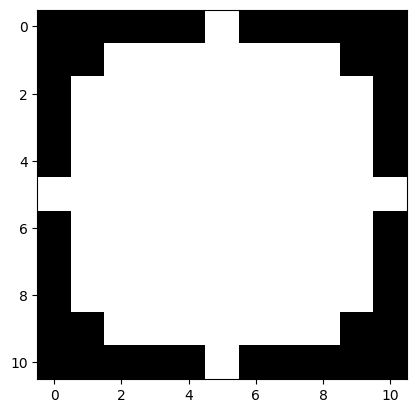

In [103]:
# @Test Circle Image
circle = get_circle_image(5)
print(circle)
plt.imshow(circle * 255, cmap='gray', vmin=0, vmax=255);

In [95]:
# Opening 
def opening(img, se, origin):
    return dilation(erosion(img, se, origin), se, origin)

# Closing
def closing(img, se, origin):
    return erosion(dilation(img, se, origin), se, origin)

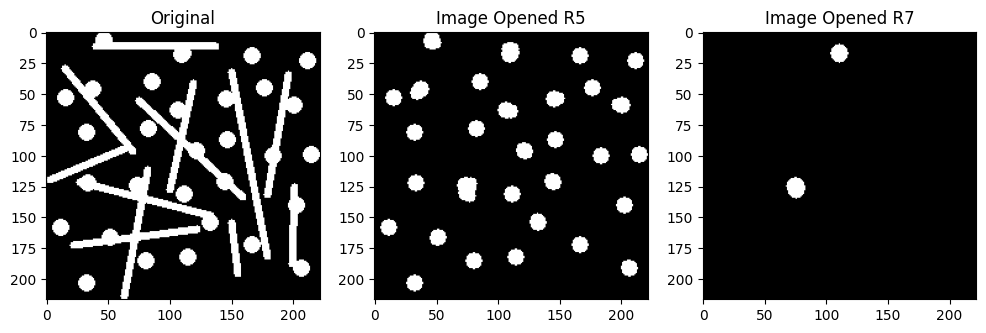

In [128]:
# Exercício #1 
img1 = cv2.imread("art3.png", cv2.IMREAD_GRAYSCALE)
# get circle image with radius x
se_circle = get_circle_image(5)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v1 = opening(img1, se_circle, circle_center) * 255

se_circle = get_circle_image(7)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v2 = opening(img1, se_circle, circle_center) * 255

# Printing
images = np.array([[img1, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened R5', 'Image Opened R7']])
print_images(labels, images, _figsize=(12, 12))


2)

a) Obter linhas verticais. Abertura com elemento estruturante vertical 3x9
b) Obter linhas horizontais. Abertura com elemento estruturante horizontal 9x3. Tente eliminar as linhas erradas usando uma máscara maior


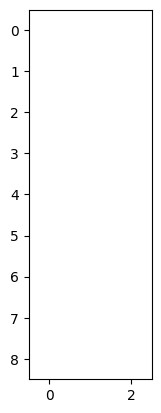

In [130]:
# get vertical line
se = np.ones((9, 3), dtype=np.uint8)
plt.imshow(se * 255, cmap='gray', vmin=0, vmax=255);

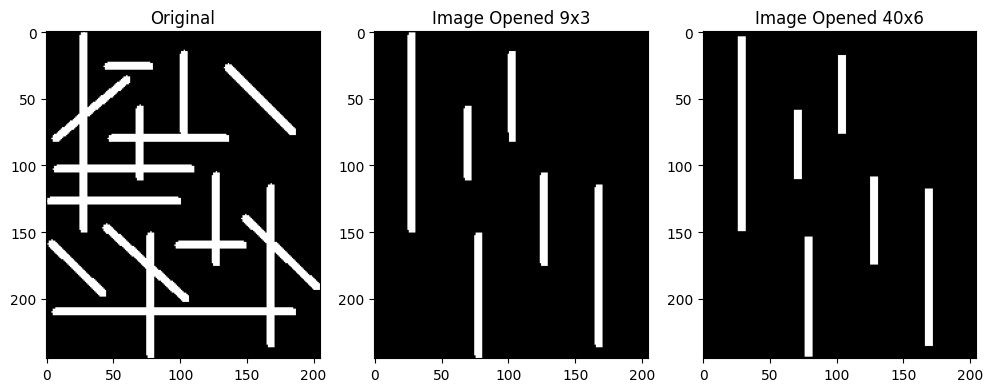

In [146]:
# Exercicio #2a Pegando linhas verticais 
img2 = cv2.imread("art2.png", cv2.IMREAD_GRAYSCALE)

# get vertical line
se = np.ones((9, 3), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v1 = opening(img2, se, origin) * 255

# get vertical line
se = np.ones((40, 6), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v2 = opening(img2, se, origin) * 255

# Printing
images = np.array([[img2, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened 9x3', 'Image Opened 40x6']])
print_images(labels, images, _figsize=(12, 12))

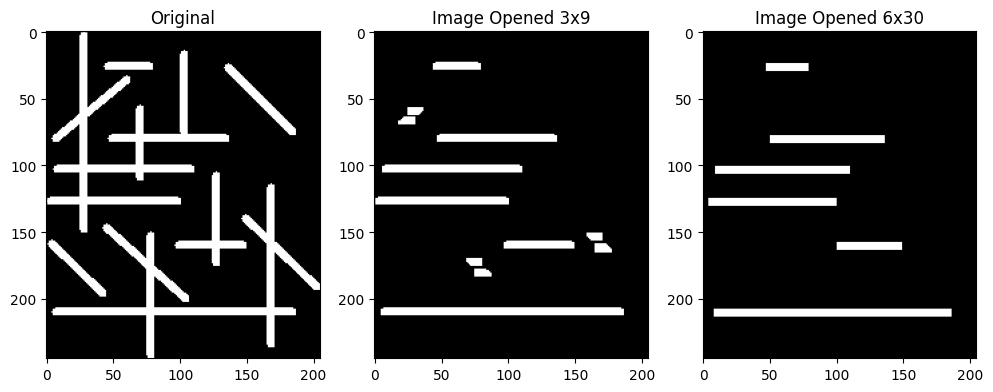

In [206]:
# Exercicio #2b Pegando linhas Horizontais 
img2 = cv2.imread("art2.png", cv2.IMREAD_GRAYSCALE)

# get vertical line
se = np.ones((3, 9), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v1 = opening(img2, se, origin) * 255

# get vertical line
se = np.ones((6, 30), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v2 = opening(img2, se, origin) * 255

# Printing
images = np.array([[img2, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened 3x9', 'Image Opened 6x30']])
print_images(labels, images, _figsize=(12, 12))

3)

a) Theshold (t=210)

b) Utilizando abertura com elemento circular de 11 pixels para reter as células grandes

c) É possível reter somente os objetos pequenos utilizando a operação abertura?

c) Creio que não pois a abertura é uma operação que remove ruídos, logo, se o objeto for pequeno (menor que o elemento estruturante), ele será removido

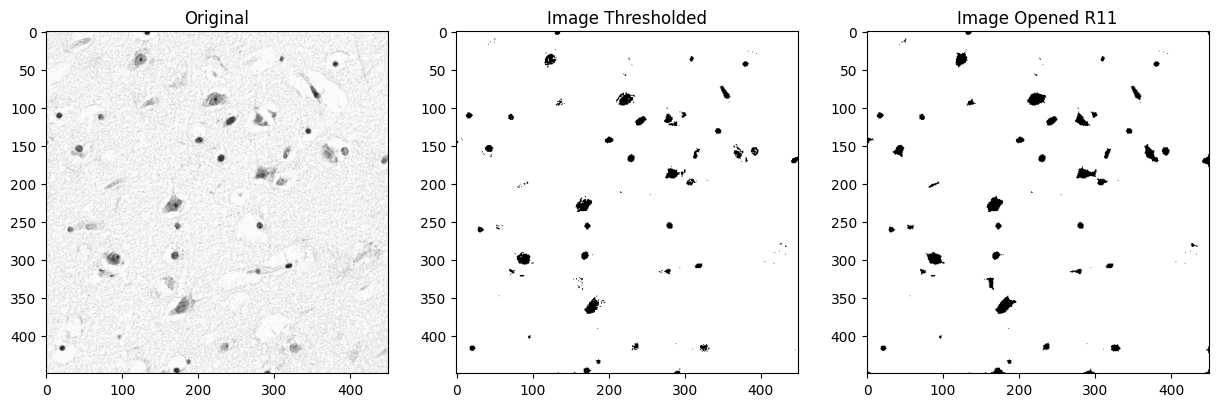

In [263]:
img3 = cv2.imread("cel4.png", cv2.IMREAD_GRAYSCALE)
# Com o threshold de 210 fica com muito ruído, logo, o threshold aplicado para melhor desempenho foi o de 180 
img3_thresholded = threshold_image(img3.copy(), 170)

# get circle image with radius 11 x 11: Aqui considerei a imagem toda com 11 pixels w e 11 pixels h, logo, o raio é 5
se_circle = get_circle_image(5)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v1 = opening(img3_thresholded, se_circle, circle_center) * 255

# Printing
images = np.array([[img3, img3_thresholded, img_result_v1]])
labels = np.array([['Original', 'Image Thresholded', 'Image Opened R11']])
print_images(labels, images, _figsize=(15, 15))


4)
Utilizando os conceitos já aprendidos na disciplina, faça um código que calcula a quantidade de objetos da imagem abaixo. Pode-se utilizar funções prontas do opencv (não para realizar a contagem em si, mas para realizar os passos necessários)

Image Shape: (3456, 4608)
Start:  12:24:18.559699
Number of beans: 114
1 18260
2 11952
3 39879
4 21987
5 30702
6 42507
7 27946
8 36987
9 21979
10 29094
11 29925
12 1316
13 31546
14 30763
15 18220
16 5532
17 58663
18 23732
19 33071
20 27595
21 31424
22 15374
23 903
24 900
25 25961
26 32216
27 37798
28 2595
29 30128
30 18585
31 27908
32 40731
33 32104
34 5343
35 32162
36 36807
37 15265
38 34186
39 34307
40 24561
41 29324
42 37483
43 39198
44 36773
45 32352
46 26151
47 3783
48 38236
49 24935
50 32633
51 1595
52 24826
53 21102
54 17597
55 28637
56 25328
57 26524
58 14581
59 25933
60 30468
61 21405
62 26557
63 24664
64 2222
65 30977
66 30914
67 31041
68 1252
69 996
70 38176
71 24333
72 3315
73 35224
74 31940
75 35414
76 36301
77 13386
78 36802
79 31405
80 13100
81 9989
82 34602
83 45368
84 4992
85 3823
86 1985
87 31114
88 39779
89 33262
90 33380
91 40062
92 25517
93 34212
94 21043
95 1418
96 36346
97 31430
98 41399
99 35936
100 1164
101 1088
102 32450
103 7777
104 23712
105 883
106 853
107 

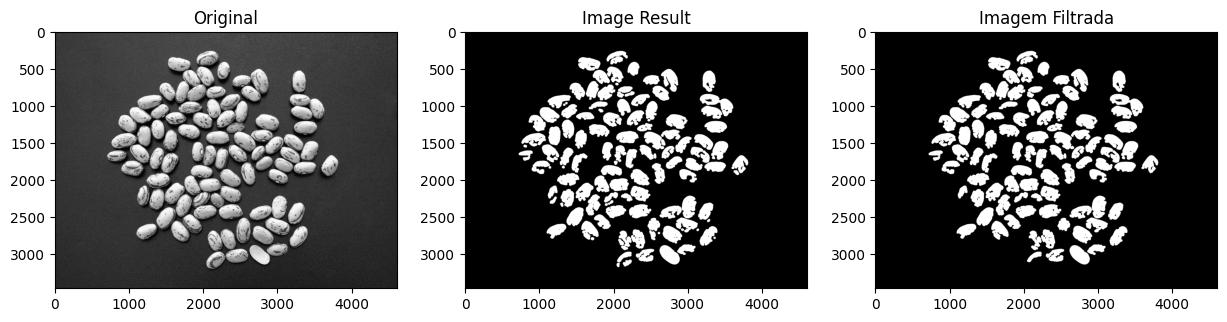

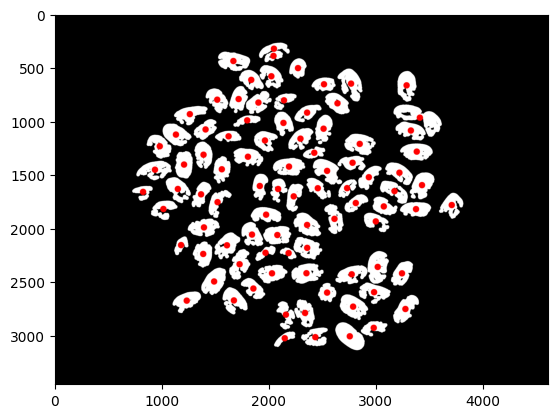

In [240]:
img4 = cv2.imread("feijao.jpg", cv2.IMREAD_GRAYSCALE)
print("Image Shape: " + str(img4.shape))
# apply threshold
img4_thresholded = threshold_image(img4.copy(), 115)
# closing with small object
se_circle = get_circle_image(16)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
print("Start: ", datetime.now().time())
img_result_v1 = opening(img4_thresholded, se_circle, circle_center) * 255
#img_result_v1 = erosion(img4_thresholded, se_circle, circle_center) * 255

# n_objects, labels = cv2.connectedComponents(img_result_v1)
n_objects, labels, stats, centroids = cv2.connectedComponentsWithStats(img_result_v1, connectivity=8)
print("Number of beans: " + str(n_objects - 1))

# Define a minimum component size threshold
min_component_size = 9000  # Adjust this value based on your image

# Initialize a mask for large components
large_components_mask = np.zeros_like(img_result_v1)
filtered_image = np.zeros_like(img_result_v1)

# Iterate through the labeled components
for label in range(1, n_objects):  # Start from 1 to exclude background
    # Create a mask for the current label (transforming from boolean to uint8)
    component_mask = np.uint8(labels == label)

    # Calculate the size of the component (counting the pixels different from black)
    component_size = cv2.countNonZero(component_mask)
    print(label, component_size)
    # If the component size is above the threshold, add it to the large components mask
    if component_size >= min_component_size:
        large_components_mask += component_mask
        filtered_image[labels == label] = 255  # Keep the component
#    if stats[label, cv2.CC_STAT_AREA] >= min_component_size:
#        filtered_image[labels == label] = 255  # Keep the component

# Create a colored version of the labeled image for visualization
colored_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR)
# Define colors for drawing points (you can customize these)
point_color = (255, 0, 0)  # Red in BGR color format
point_radius = 30  # Radius of the drawn point

# Re-label the large components
#num_large_components, labeled_large_components = cv2.connectedComponents(large_components_mask)
num_large_components, labeled_large_components, stats_lc, centroids_lc = cv2.connectedComponentsWithStats(large_components_mask, connectivity=8)
# Iterate through the labeled components
for label in range(1, num_large_components):  # Start from 1 to exclude background
    centroid_x, centroid_y = centroids_lc[label]  # Get centroid coordinates
    centroid_position = (int(centroid_x), int(centroid_y))
    # Draw a colored point at the centroid position
    cv2.circle(colored_image, centroid_position, point_radius, point_color, -1)  # -1 fills the circle  
    
# Subtract 1 from the total count to exclude the background label (0)
num_large_objects = num_large_components - 1

# Display the total number of large connected components (objects)
print("Total Number of Large Connected Components (Objects):", num_large_objects)

print("End: ", datetime.now().time())

# Printing
images = np.array([[img4, img_result_v1, filtered_image]])
labels = np.array([['Original', 'Image Result', 'Imagem Filtrada']])
print_images(labels, images, _figsize=(15, 15))
plt.imshow(colored_image);

5.  Utilize a transformada hit or miss para localizar o logotipo da UFU. Escolha um deles

Start:  00:20:13.963396


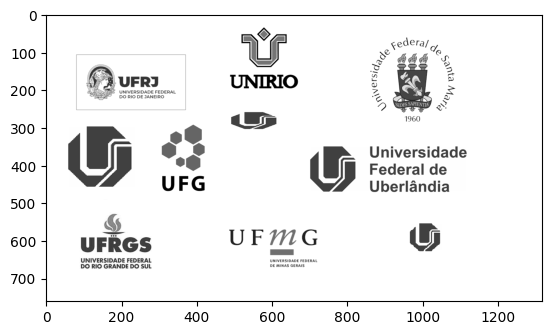

In [211]:
img5 = cv2.imread("logotipos.png", cv2.IMREAD_GRAYSCALE)


plt.imshow(img5, cmap='gray', vmin=0, vmax=255);

  6. Utilize operadores morfológicos para extração de fronteiras dos feijões. Mostre o resultado junto com a imagem original